In [1]:
import numpy as np
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.misc as misc
import pose_model
import math

%matplotlib inline

RESIZE_DIM=368

FLAGS = tf.app.flags.FLAGS
tf.app.flags.DEFINE_string('model_dir', '/tmp/pose_train',
                           """Directory where model is stored.""")
tf.app.flags.DEFINE_string('image_file', 
                           '/Users/xuehan.xiong/Google Drive/datasets/human_pose/images/000001163.jpg',
                           """Absolute path to image file.""")

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def resize_image(image):
    height,width = image.shape[:2]
    scale = float(RESIZE_DIM) / float(height)
    resized_image = cv2.resize(image,(0,0),fx=scale,fy=scale)
    assert resized_image.shape[0] == RESIZE_DIM
    return resized_image

def preprocess(image):
    image = np.float32(image)
    image = image * (1. / 255) - 0.5
    return image

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def plot_heatmaps(image, heatmaps):
    f, axarr = plt.subplots(4, 4)
    for i in xrange(4):
        for j in xrange(4):
            if i == 0 and j == 0:
                axarr[i,j].imshow(image)
                axarr[i,j].set_title("Image")
            else:
                axarr[i,j].imshow(heatmaps[:,:,4*i+j-1])
                axarr[i,j].set_title('')
            axarr[i,j].axis('off')
    plt.show()

In [3]:
image_path = FLAGS.image_file;
if not tf.gfile.Exists(image_path):
    tf.logging.fatal('File does not exist %s', image_path)
image_data = cv2.imread(image_path);
resized_image = resize_image(image_data)
resized_image = preprocess(resized_image)
assert resized_image.shape[2] == 3
height,width = resized_image.shape[:2]
resized_image = np.reshape(resized_image,(1,height,width,3))

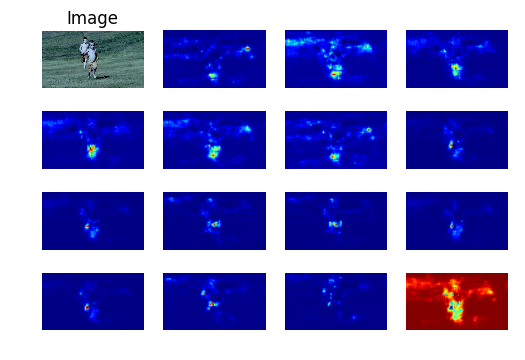

In [4]:
with tf.Graph().as_default():
    image_placeholder = tf.placeholder(tf.float32, shape=(None,None,None,3))
    heatmaps0 = pose_model.inference(image_placeholder,0.0)
    score0 = tf.sigmoid(heatmaps0)
    saver = tf.train.Saver()
    with tf.Session() as sess:
        model_checkpoint_path = os.path.join(FLAGS.model_dir,'model.ckpt-6466')
        saver.restore(sess, model_checkpoint_path)
        score0_val = sess.run(score0, 
                              feed_dict={image_placeholder: resized_image})
        plot_heatmaps(image_data, score0_val[0,:,:,:])
        